In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, Conv2DTranspose, BatchNormalization, LeakyReLU, UpSampling2D
from tensorflow.keras import layers, losses
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

from utils.image_formatting import *

%load_ext autoreload
%autoreload 2

n=256

In [2]:
X, y = preprocess_images2(artists=list(PAINTER_DICT.keys()), n_imgs=1000, dropout_rate=None)
X_aug = np.flip(X, axis=2)
y_aug = y
X = np.concatenate((X, X_aug), axis=0)
y = np.concatenate((y, y_aug), axis=0)
X_train, X_val, _ , _ = train_test_split(X, y, test_size=0.1)   

print(X_train.shape)
print(X_val.shape)

(7207, 256, 256, 3)
(801, 256, 256, 3)


In [3]:
# accuracy reach 72%
CAE = Sequential()
CAE.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1), 
               activation='relu', 
               input_shape=(n, n, 3), 
               padding='same', name = 'Conv2D_1'))
CAE.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='MaxPool_1'))

CAE.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(1,1), 
               activation='relu', 
               padding='same', 
               name='Conv2D_2'))
CAE.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='MaxPool_2'))

CAE.add(Conv2D(filters=128, kernel_size=(5, 5), strides=(1,1), 
               activation='relu', 
               padding='same', 
               name='Conv2D_3'))
CAE.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='MaxPool_3'))

CAE.add(UpSampling2D(interpolation='bilinear', name='UpSample_1'))
CAE.add(Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same', name='DeConv2D_1'))

CAE.add(UpSampling2D(interpolation='bilinear', name='UpSample_2'))
CAE.add(Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same', name='De2DTrans_2'))

CAE.add(UpSampling2D(interpolation='bilinear', name='UpSample_3'))
CAE.add(Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same', name='De2DTrans_3'))

CAE.add(Conv2DTranspose(filters=3, kernel_size=(1, 1), strides=(1, 1), activation='relu', name='Conv2DTrans_recon'))
CAE.summary()
CAE.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
            loss=keras.losses.MeanSquaredError(), metrics=tf.keras.metrics.Accuracy())        # compile model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 256, 256, 32)      2432      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 128, 128, 32)      0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 128, 128, 64)      51264     
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 64, 64, 64)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 64, 64, 128)       204928    
_________________________________________________________________
MaxPool_3 (MaxPooling2D)     (None, 32, 32, 128)       0         
_________________________________________________________________
UpSample_1 (UpSampling2D)    (None, 64, 64, 128)       0

In [4]:
# Train CAE (Unsupervised Training)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            min_delta = 2, 
                                            mode = 'min', 
                                            patience=3)
CAE_train_history = CAE.fit(x=X_train, y=X_train, 
                            batch_size=32, 
                            epochs=30, 
                            validation_data=(X_val, X_val),
                            callbacks=[callback])

Epoch 1/30
226/226 [==============================] - 81s 323ms/step - loss: 8989.6803 - accuracy: 0.0030 - val_loss: 361.8503 - val_accuracy: 0.0176
Epoch 2/30
226/226 [==============================] - 71s 316ms/step - loss: 341.5294 - accuracy: 0.0136 - val_loss: 261.3903 - val_accuracy: 0.0183
Epoch 3/30
226/226 [==============================] - 72s 320ms/step - loss: 277.4448 - accuracy: 0.0146 - val_loss: 243.3220 - val_accuracy: 0.0190
Epoch 4/30
226/226 [==============================] - 73s 323ms/step - loss: 231.7140 - accuracy: 0.0160 - val_loss: 200.1798 - val_accuracy: 0.0193
Epoch 5/30
226/226 [==============================] - 74s 326ms/step - loss: 217.3426 - accuracy: 0.0157 - val_loss: 195.9404 - val_accuracy: 0.0198
Epoch 6/30
226/226 [==============================] - 74s 327ms/step - loss: 202.8563 - accuracy: 0.0159 - val_loss: 171.6355 - val_accuracy: 0.0199
Epoch 7/30
226/226 [==============================] - 74s 327ms/step - loss: 187.1985 - accuracy: 0.0173 

In [35]:
# Save model
CAE_path = "models/cae"
CAE.save(CAE_path)

INFO:tensorflow:Assets written to: models/cae/assets


In [6]:
from tensorflow import keras
CAE = keras.models.load_model('models/cae')

# Visualize encoded resuslts

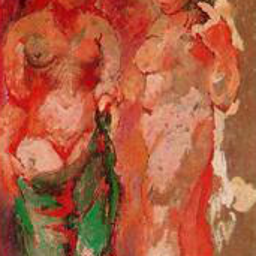

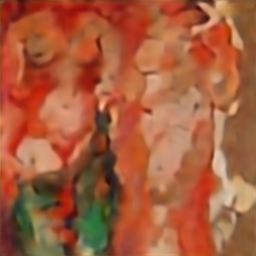

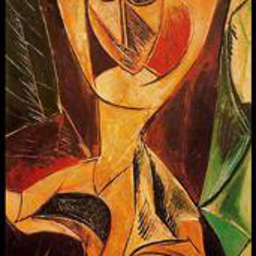

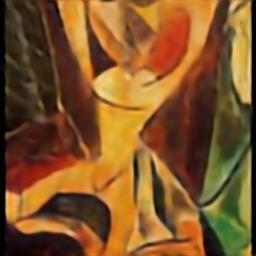

In [7]:
# show the output of reconstruction
from PIL import Image
import numpy as np

for i in range(2):
    original_image = Image.fromarray(X[i])
#     original_image_path = 'comparison/original_image.png'
#     original_image.save(original_image_path)
    expand = np.expand_dims(X[i], 0)
    reconstruct_output = CAE(expand).numpy().reshape((n, n, 3))
    output_max = np.max(reconstruct_output)
    output_min = np.min(reconstruct_output)
    reconstruct_output = (reconstruct_output - output_min) / (output_max - output_min) * (n-1)
    reconstruct_output = reconstruct_output.astype(np.uint8)
    reconstruct_image = Image.fromarray(reconstruct_output)
#     reconstruct_image_path = 'comparison/reconstruct_image.png'
#     reconstruct_image.save(reconstruct_image_path)
    
    original_image.show()
    reconstruct_image.show()

# Train Fully Connected Layers

In [8]:
# Use the hyperparameter learned from CAE and classify the paints
# artists = ['pierre-auguste-renoir', 'vincent-van-gogh', 'pablo-picasso']
artists = ['rembrandt', 'pierre-auguste-renoir', 'vincent-van-gogh']
# artists=list(PAINTER_DICT.keys())

X, y = preprocess_images2(artists=artists, n_imgs=1000, dropout_rate=0)
X_aug = np.flip(X, axis=2)
y_aug = y
X = np.concatenate((X, X_aug), axis=0)
y = np.concatenate((y, y_aug), axis=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)


print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2565, 256, 256, 3) (2565,)
(285, 256, 256, 3) (285,)


In [27]:
cae_output = Model(inputs = CAE.input, outputs = CAE.layers[-6].output, name = 'cae_output')
for layer in cae_output.layers:
    layer.trainable = False
following_layers = Sequential()
input_shape = (cae_output.output.shape[1], cae_output.output.shape[2], cae_output.output.shape[3])
following_layers.add(tf.keras.layers.Input(shape=input_shape))
following_layers.add(Flatten(name = 'flatten'))
following_layers.add(Dropout(0.1, name = "Dropout_1"))
following_layers.add(Dense(128, activation = 'relu', 
                           kernel_regularizer = 'l2', 
#                            bias_regularizer = 'l2', 
                           name = "Dense_1"))
following_layers.add(LeakyReLU(0.05))

following_layers.add(Dense(64, activation = 'relu', 
                           kernel_regularizer = 'l2', 
#                            bias_regularizer = 'l2', 
                           name = "Dense_2"))
following_layers.add(LeakyReLU(0.05))

following_layers.add(Dense(32, activation = 'relu', 
                           kernel_regularizer = 'l2', 
#                            bias_regularizer = 'l2', 
                           name = "Dense_3"))
following_layers.add(LeakyReLU(0.05))

following_layers.add(Dense(3, activation = 'softmax', name = "softmax"))
painter_classifier = Model(inputs = cae_output.inputs, outputs = following_layers(cae_output.output))
painter_classifier.summary()
painter_classifier.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                           loss = 'sparse_categorical_crossentropy', 
                           metrics = ['accuracy'])


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1_input (InputLayer)  [(None, 256, 256, 3)]     0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 256, 256, 32)      2432      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 128, 128, 32)      0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 128, 128, 64)      51264     
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 64, 64, 64)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 64, 64, 128)       204928    
_________________________________________________________________
MaxPool_3 (MaxPooling2D)     (None, 32, 32, 128)       0   

In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            min_delta = 0.005, 
                                            mode = 'max', 
                                            patience=5)
cae_training_history = painter_classifier.fit(x=X_train, y=y_train, 
                                              batch_size=32, epochs=30, 
                                              validation_data=(X_val, y_val),
                                              callbacks = [callback])

Epoch 1/30
81/81 [==============================] - 6s 66ms/step - loss: 264.5576 - accuracy: 0.4312 - val_loss: 83.4485 - val_accuracy: 0.4105
Epoch 2/30
81/81 [==============================] - 5s 64ms/step - loss: 30.3636 - accuracy: 0.6439 - val_loss: 43.0321 - val_accuracy: 0.6842
Epoch 3/30
81/81 [==============================] - 5s 64ms/step - loss: 32.0077 - accuracy: 0.6639 - val_loss: 20.4910 - val_accuracy: 0.7439
Epoch 4/30
81/81 [==============================] - 5s 64ms/step - loss: 14.0982 - accuracy: 0.7857 - val_loss: 23.9540 - val_accuracy: 0.6877
Epoch 5/30
81/81 [==============================] - 5s 64ms/step - loss: 15.5098 - accuracy: 0.7781 - val_loss: 18.7550 - val_accuracy: 0.6982
Epoch 6/30
81/81 [==============================] - 5s 64ms/step - loss: 20.6869 - accuracy: 0.7792 - val_loss: 13.0880 - val_accuracy: 0.7368
Epoch 7/30
81/81 [==============================] - 5s 64ms/step - loss: 7.1227 - accuracy: 0.8696 - val_loss: 10.8350 - val_accuracy: 0.7544

In [36]:
# Save model
PC_path = "models/pc"
painter_classifier.save(PC_path)
from tensorflow import keras
PC = keras.models.load_model('models/pc')

INFO:tensorflow:Assets written to: models/pc/assets


# Testing

In [30]:
# artists = ['rembrandt', 'pierre-auguste-renoir', 'vincent-van-gogh']

X_true, y_true = preprocess_images2(artists=artists, n_imgs=25, test_set=True)

print(X_true.shape, y_true.shape)

(75, 256, 256, 3) (75,)


In [31]:
y_pred = painter_classifier.predict(X_true)
y_pred = np.argmax(y_pred, axis = 1)

In [32]:
confusion_matrix(y_true, y_pred)

array([[12,  5,  8],
       [ 0, 21,  4],
       [ 1,  1, 23]])

In [33]:
accuracy_score(y_true, y_pred)

0.7466666666666667